### 📘 Aggrigator: Interactive Guide

Welcome to the **Aggrigator** tutorial notebook!

In this walkthrough, you'll learn how to:
- Explore and apply different **aggregation strategies** to uncertainty maps.
- Evaluate and compare the output of these strategies.
- Save results for analysis.
- Visualize summary results easily.

> Uncertainty aggregation helps you reduce complex per-pixel predictions to single-number scores, enabling easier model evaluation and comparison.


### 🧰 Setup & Imports

In [1]:
# Necessary imports
import matplotlib.pyplot as plt
import numpy as np

%load_ext autoreload
%autoreload 2
from aggrigator.methods import AggregationMethods as am
from aggrigator.strategylist import StrategyList
from aggrigator.summary import AggregationSummary
from aggrigator.uncertainty_maps import UncertaintyMap
from aggrigator.datasets import generate_random_binary_array_with_squares



### 🔧 Generate Example Uncertainty Maps

We'll use a small synthetic dataset to illustrate the aggregation methods. Each array contains a binary uncertainty map with randomly placed squares.

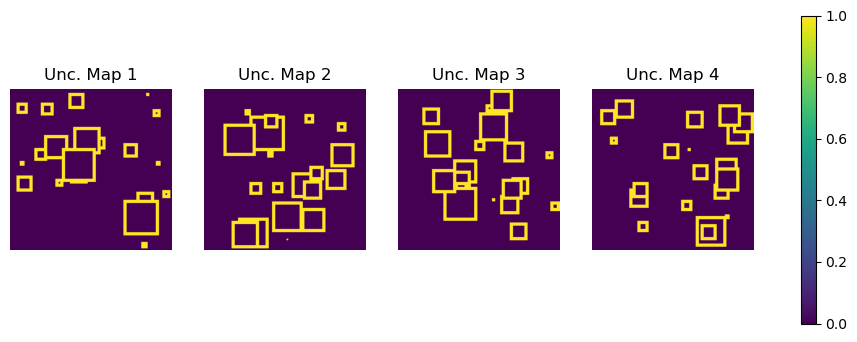

In [57]:
# DATA
N = 4
# Create a list of uncertainty arrays
uncertainty_arrays = [generate_random_binary_array_with_squares(shape=(100, 100), num_squares=20, square_size_mean=10) for _ in range(N)] 

# Plot arrays
fig, axs = plt.subplots(1, N, figsize=(12, 4))
for i, array in enumerate(uncertainty_arrays):
    axs[i].imshow(array, cmap='viridis')
    axs[i].set_title(f"Unc. Map {i+1}")
    axs[i].axis('off')
fig.colorbar(axs[0].get_children()[0], ax=axs.ravel().tolist())
plt.show()

### 📦 Wrap Arrays into UncertaintyMap Objects

We’ll wrap each array in an `UncertaintyMap` object so they can be used with Aggrigator’s aggregation methods.

In [58]:
# Define uncertainty map objects containing additional information:
# array: the uncertainty map array
# mask (optional):the predicted segmentation mask corresponding to the uncertainty map
# name (optional): a name for the uncertainty map

unc_maps = [UncertaintyMap(array=array, mask=None, name=f"Map {idx}") for idx, array in enumerate(uncertainty_arrays)]

### ⚙️ Apply Aggregation Strategies

Now let’s apply some basic strategies to a single uncertainty map to see what they do.


In [59]:
unc_map = unc_maps[0]
# Global Average
mean = am.mean(unc_map, None) # Include None if aggrgegation strategy is parameter free.
# Above Threshoold Average
threshold = 0.7
ata = am.above_threshold_mean(unc_map, threshold)
# Above Quantile Average
quantile = 0.7
aqa = am.above_quantile_mean(unc_map, quantile)

print(f"Mean: {mean}")
print(f"Above Threshold Average: {ata}")
print(f"Above Quantile Average: {aqa}")

Mean: 0.0965
Above Threshold Average: 1.0
Above Quantile Average: 0.0965


### 📊 Compare Strategies Over Multiple Maps

You can compare strategies across all maps at once using an `AggregationSummary`.


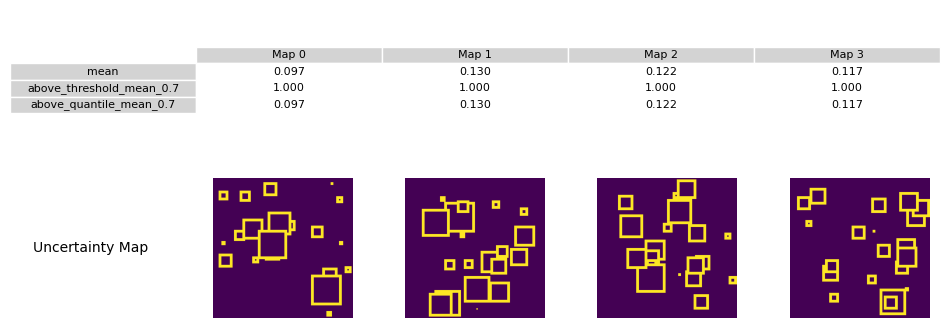

,Name,Map 0,Map 1,Map 2,Map 3
0,mean,0.0965,0.1302,0.1221,0.117
1,above_threshold_mean_0.7,1.0000,1.0000,1.0000,1.000
2,above_quantile_mean_0.7,0.0965,0.1302,0.1221,0.117


In [60]:
strategy_list = [(am.mean, None), (am.above_threshold_mean, 0.7), (am.above_quantile_mean, 0.7)]


summary = AggregationSummary(strategy_list)
results = summary.apply_methods(unc_maps, save_to_excel=False, do_plot=True)

# NOTE: Results are stored in a dataframe
results 

### 📈 Analyze a Strategy Across Parameters

Let's see how the quantile threshold affects results.

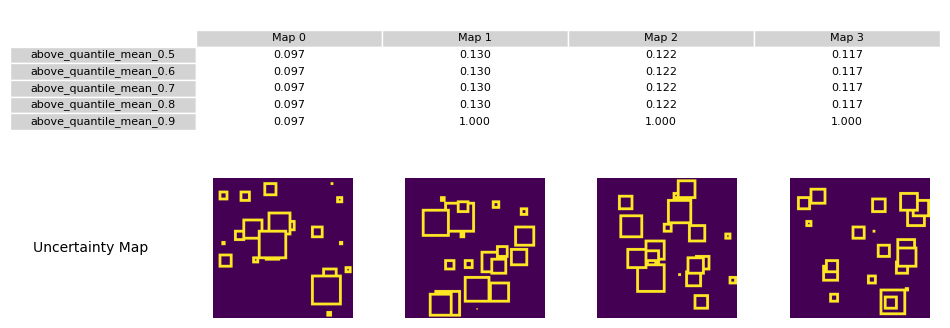

,Name,Map 0,Map 1,Map 2,Map 3
0,above_quantile_mean_0.5,0.0965,0.1302,0.1221,0.117
1,above_quantile_mean_0.6,0.0965,0.1302,0.1221,0.117
2,above_quantile_mean_0.7,0.0965,0.1302,0.1221,0.117
3,above_quantile_mean_0.8,0.0965,0.1302,0.1221,0.117
4,above_quantile_mean_0.9,0.0965,1.0000,1.0000,1.000


In [61]:
# Use aggregation summary to compare one strategy across varying parameters
quantiles = [0.5, 0.6, 0.7, 0.8, 0.9]
strategy_list = [(am.above_quantile_mean, quantile) for quantile in quantiles]

summary = AggregationSummary(strategy_list)
results = summary.apply_methods(unc_maps, save_to_excel=False, do_plot=True)

# NOTE: Results are stored in a dataframe
results 

### 🧩 Using Segmentation Masks

You can optionally attach segmentation masks to uncertainty maps to enable class-aware aggregation.


In [62]:
# Using the same data for both mask and array for illustration
arrays = uncertainty_arrays
masks = uncertainty_arrays  # typically this would be model predictions
names = [f"Map {idx}" for idx in range(len(arrays))]

unc_maps = [
    UncertaintyMap(array=array, mask=mask, name=name)
    for array, mask, name in zip(arrays, masks, names)
]

### 🎯 Class-Aware Aggregation

You can now apply methods that aggregate uncertainty separately for different classes (e.g., background and foreground).

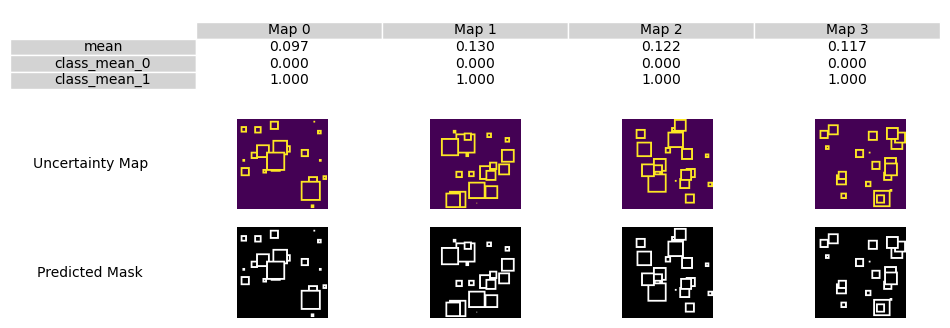

,Name,Map 0,Map 1,Map 2,Map 3
0,mean,0.0965,0.1302,0.1221,0.117
1,class_mean_0,0.0000,0.0000,0.0000,0.000
2,class_mean_1,1.0000,1.0000,1.0000,1.000


In [63]:
strategy_list = [
    (am.mean, None),
    (am.class_mean, 0),  # class 0 = background
    (am.class_mean, 1),  # class 1 = foreground
]

summary = AggregationSummary(strategy_list)
results = summary.apply_methods(unc_maps, save_to_excel=False, do_plot=True)

results